In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Read the data
df = pd.read_excel('../../data/IAG.xlsx')

# Define features based on importance
categorical_features = [
    'iag_business_unit_ug',
    'iag_age_band_auto',
    'iag_tenure_band_enum',
    'iag_site_ug',
    'iag_product_type_auto',
    'iag_region_ug'
]

numeric_features = [
    'iag_trust_confidence_scale11',
    'iag_value_price_of_policy_reflects_scale11'
]

# Custom transformer for binning numeric features - using the same bins as before
class NumericBinner(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Using the same bins as in our previous analysis
        self.trust_bins = [-np.inf, 5, 7, 8, 9, np.inf]
        self.price_bins = [-np.inf, 5, 6, 7, 8, np.inf]
        self.trust_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
        self.price_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        # Apply binning to trust confidence - same as previous code
        X_copy['iag_trust_confidence_scale11'] = pd.cut(
            X_copy['iag_trust_confidence_scale11'],
            bins=self.trust_bins,
            labels=self.trust_labels
        )
        # Apply binning to price value - same as previous code
        X_copy['iag_value_price_of_policy_reflects_scale11'] = pd.cut(
            X_copy['iag_value_price_of_policy_reflects_scale11'],
            bins=self.price_bins,
            labels=self.price_labels
        )
        return X_copy

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('binner', NumericBinner()),
    ('onehot', OneHotEncoder(drop='first', sparse=False))  # Convert binned categories to dummy variables
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))  # Convert categories to dummy variables
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# First, drop rows with missing values in key features
features_to_check = numeric_features + categorical_features
df_clean = df.dropna(subset=features_to_check)

# Prepare X and y
X = df_clean[features_to_check]
y = df_clean['Likely to recommend']

# Create label encoder for target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Fit and transform the features
X_transformed = pipeline.fit_transform(X)

# Get feature names after transformation
def get_feature_names(pipeline, feature_names):
    # Get names for binned numeric features
    numeric_features_binned = []
    for feature in numeric_features:
        if feature == 'iag_trust_confidence_scale11':
            numeric_features_binned.extend([f'{feature}_{label}' for label in 
                                          ['Low', 'Moderate', 'High', 'Very High']])  # Dropped 'Very Low' as reference
        else:
            numeric_features_binned.extend([f'{feature}_{label}' for label in 
                                          ['Fair', 'Good', 'Very Good', 'Excellent']])  # Dropped 'Poor' as reference
    
    # Get names for categorical features
    categorical_features_encoded = []
    for feature in categorical_features:
        unique_values = sorted(df_clean[feature].unique())[1:]  # Exclude first category (reference level)
        categorical_features_encoded.extend([f'{feature}_{val}' for val in unique_values])
    
    return numeric_features_binned + categorical_features_encoded

feature_names = get_feature_names(pipeline, features_to_check)

# Convert to DataFrame with proper column names
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

# Add encoded target variable
X_transformed_df['target'] = y_encoded

# Display information about the transformed dataset
print("Shape of transformed data:", X_transformed_df.shape)
print("\nTarget variable encoding:")
for i, label in enumerate(le.classes_):
    print(f"{label}: {i}")

print("\nFirst few rows of transformed data:")
print(X_transformed_df.head())

# Display distribution of target variable
print("\nTarget variable distribution:")
print(pd.Series(y_encoded).value_counts().sort_index())

Shape of transformed data: (8457, 79)

Target variable encoding:
Detract: 0
Passive: 1
Promote: 2
Super Detract: 3

First few rows of transformed data:
   iag_trust_confidence_scale11_Low  iag_trust_confidence_scale11_Moderate  \
0                               0.0                                    0.0   
1                               0.0                                    1.0   
2                               0.0                                    0.0   
3                               0.0                                    0.0   
4                               0.0                                    0.0   

   iag_trust_confidence_scale11_High  iag_trust_confidence_scale11_Very High  \
0                                0.0                                     0.0   
1                                0.0                                     0.0   
2                                1.0                                     0.0   
3                                1.0                       

e:\Apps\anaconda3\envs\iag\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
e:\Apps\anaconda3\envs\iag\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data pipeline executed before train-test split which is incorrect. Fixed in next steps.

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Read the data
df = pd.read_excel('../../data/IAG.xlsx')

# Define features based on importance
categorical_features = [
    'iag_business_unit_ug',
    'iag_age_band_auto',
    'iag_tenure_band_enum',
    'iag_site_ug',
    'iag_product_type_auto',
    'iag_region_ug'
]

numeric_features = [
    'iag_trust_confidence_scale11',
    'iag_value_price_of_policy_reflects_scale11'
]

# Custom transformer for binning numeric features
class NumericBinner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.trust_bins = [-np.inf, 5, 7, 8, 9, np.inf]
        self.price_bins = [-np.inf, 5, 6, 7, 8, np.inf]
        self.trust_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
        self.price_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['iag_trust_confidence_scale11'] = pd.cut(
            X_copy['iag_trust_confidence_scale11'],
            bins=self.trust_bins,
            labels=self.trust_labels
        )
        X_copy['iag_value_price_of_policy_reflects_scale11'] = pd.cut(
            X_copy['iag_value_price_of_policy_reflects_scale11'],
            bins=self.price_bins,
            labels=self.price_labels
        )
        return X_copy

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('binner', NumericBinner()),
    ('onehot', OneHotEncoder(drop='first', sparse=False))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# Drop rows with missing values in key features
features_to_check = numeric_features + categorical_features
df_clean = df.dropna(subset=features_to_check)

# Prepare X and y
X = df_clean[features_to_check]
y = df_clean['Likely to recommend']

# Create label encoder for target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Fit and transform the features
X_transformed = pipeline.fit_transform(X)

# Get feature names after transformation
def get_feature_names(pipeline, feature_names):
    numeric_features_binned = []
    for feature in numeric_features:
        if feature == 'iag_trust_confidence_scale11':
            numeric_features_binned.extend([f'{feature}_{label}' for label in 
                                          ['Low', 'Moderate', 'High', 'Very High']])
        else:
            numeric_features_binned.extend([f'{feature}_{label}' for label in 
                                          ['Fair', 'Good', 'Very Good', 'Excellent']])
    
    categorical_features_encoded = []
    for feature in categorical_features:
        unique_values = sorted(df_clean[feature].unique())[1:]
        categorical_features_encoded.extend([f'{feature}_{val}' for val in unique_values])
    
    return numeric_features_binned + categorical_features_encoded

feature_names = get_feature_names(pipeline, features_to_check)

# Convert to DataFrame with proper column names
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

# Add encoded target variable
X_transformed_df['target'] = y_encoded

# Display information about the transformed dataset
print("Shape of transformed data:", X_transformed_df.shape)
print("\nTarget variable encoding:")
for i, label in enumerate(le.classes_):
    print(f"{label}: {i}")

# Create a more readable version of the dataset
readable_df = pd.DataFrame(index=range(len(X_transformed_df)))

for feature in ['iag_trust_confidence_scale11', 'iag_value_price_of_policy_reflects_scale11',
               'iag_business_unit_ug', 'iag_age_band_auto', 'iag_tenure_band_enum',
               'iag_site_ug', 'iag_product_type_auto', 'iag_region_ug']:
    relevant_cols = [col for col in X_transformed_df.columns if col.startswith(feature)]
    categories = []
    for idx in range(len(X_transformed_df)):
        row_values = X_transformed_df.loc[idx, relevant_cols]
        if row_values.max() == 0:  # If all are 0, it's the reference category
            category = relevant_cols[0].split('_')[-1] + " (ref)"
        else:
            category = relevant_cols[row_values.argmax()].split('_')[-1]
        categories.append(category)
    readable_df[feature] = categories

readable_df['Likely_to_recommend'] = le.inverse_transform(X_transformed_df['target'])

# Display both versions of the transformed data
print("\nOne-hot encoded version (first 5 rows):")
print(X_transformed_df.head())

print("\nReadable version (first 5 rows):")
print(readable_df.head())

# Display target distribution
print("\nTarget variable distribution:")
print(pd.Series(y_encoded).value_counts().sort_index())

e:\Apps\anaconda3\envs\iag\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
e:\Apps\anaconda3\envs\iag\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Shape of transformed data: (8457, 79)

Target variable encoding:
Detract: 0
Passive: 1
Promote: 2
Super Detract: 3

One-hot encoded version (first 5 rows):
   iag_trust_confidence_scale11_Low  iag_trust_confidence_scale11_Moderate  \
0                               0.0                                    0.0   
1                               0.0                                    1.0   
2                               0.0                                    0.0   
3                               0.0                                    0.0   
4                               0.0                                    0.0   

   iag_trust_confidence_scale11_High  iag_trust_confidence_scale11_Very High  \
0                                0.0                                     0.0   
1                                0.0                                     0.0   
2                                1.0                                     0.0   
3                                1.0                   

# Data Preprocessing Pipeline

This step prepares our data for modeling by implementing a structured preprocessing pipeline. The key steps are:

## 1. Train-Test Split
- Splitting data before preprocessing to prevent data leakage
- 80-20 split with stratification to maintain target class distribution
- Random state set for reproducibility

## 2. Feature Processing
### Numeric Features (Trust and Price Value):
- Using previously validated binning strategy:
  - Trust Confidence: 5 bins ('Very Low', 'Low', 'Moderate', 'High', 'Very High')
  - Price Value: 5 bins ('Poor', 'Fair', 'Good', 'Very Good', 'Excellent')
- One-hot encoding of binned categories

### Categorical Features:
- One-hot encoding for:
  - Business Unit
  - Age Band
  - Tenure Band
  - Site
  - Product Type
  - Region
- First category dropped as reference to avoid multicollinearity

## 3. Target Variable
- Label encoded 'Likely to recommend':
  - Detract: 0
  - Passive: 1
  - Promote: 2
  - Super Detract: 3

## Purpose
- Create consistent, reproducible preprocessing workflow
- Handle missing values by removing rows (low percentage of missingness)
- Transform categorical variables appropriately for modeling
- Maintain proper separation of training and testing data

This pipeline ensures our data is properly prepared for subsequent modeling while preventing data leakage and maintaining interpretability of features.

In [3]:
# fixed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Read the data
df = pd.read_excel('../../data/IAG.xlsx')

# Define features based on importance
categorical_features = [
    'iag_business_unit_ug',
    'iag_age_band_auto',
    'iag_tenure_band_enum',
    'iag_site_ug',
    'iag_product_type_auto',
    'iag_region_ug'
]

numeric_features = [
    'iag_trust_confidence_scale11',
    'iag_value_price_of_policy_reflects_scale11'
]

# Drop rows with missing values in key features
features_to_check = numeric_features + categorical_features
df_clean = df.dropna(subset=features_to_check)

# Prepare X and y before train test split
X = df_clean[features_to_check]
y = df_clean['Likely to recommend']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Custom transformer for binning numeric features
class NumericBinner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.trust_bins = [-np.inf, 5, 7, 8, 9, np.inf]
        self.price_bins = [-np.inf, 5, 6, 7, 8, np.inf]
        self.trust_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
        self.price_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['iag_trust_confidence_scale11'] = pd.cut(
            X_copy['iag_trust_confidence_scale11'],
            bins=self.trust_bins,
            labels=self.trust_labels
        )
        X_copy['iag_value_price_of_policy_reflects_scale11'] = pd.cut(
            X_copy['iag_value_price_of_policy_reflects_scale11'],
            bins=self.price_bins,
            labels=self.price_labels
        )
        return X_copy

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('binner', NumericBinner()),
    ('onehot', OneHotEncoder(drop='first', sparse=False))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# Create label encoder for target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Fit pipeline on training data and transform both train and test
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# Get feature names after transformation
def get_feature_names(pipeline, feature_names):
    numeric_features_binned = []
    for feature in numeric_features:
        if feature == 'iag_trust_confidence_scale11':
            numeric_features_binned.extend([f'{feature}_{label}' for label in 
                                          ['Low', 'Moderate', 'High', 'Very High']])
        else:
            numeric_features_binned.extend([f'{feature}_{label}' for label in 
                                          ['Fair', 'Good', 'Very Good', 'Excellent']])
    
    categorical_features_encoded = []
    for feature in categorical_features:
        unique_values = sorted(X_train[feature].unique())[1:]
        categorical_features_encoded.extend([f'{feature}_{val}' for val in unique_values])
    
    return numeric_features_binned + categorical_features_encoded

feature_names = get_feature_names(pipeline, features_to_check)

# Convert transformed data to DataFrames
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Add encoded target variables
X_train_transformed_df['target'] = y_train_encoded
X_test_transformed_df['target'] = y_test_encoded

# Print information about the splits
print("Training set shape:", X_train_transformed_df.shape)
print("Testing set shape:", X_test_transformed_df.shape)

print("\nTarget variable encoding:")
for i, label in enumerate(le.classes_):
    print(f"{label}: {i}")

print("\nTraining set target distribution:")
print(pd.Series(y_train_encoded).value_counts().sort_index())
print("\nTesting set target distribution:")
print(pd.Series(y_test_encoded).value_counts().sort_index())

# Display first few rows of transformed training data
print("\nFirst few rows of transformed training data:")
print(X_train_transformed_df.head())

Training set shape: (6765, 78)
Testing set shape: (1692, 78)

Target variable encoding:
Detract: 0
Passive: 1
Promote: 2
Super Detract: 3

Training set target distribution:
0     371
1    1419
2    4529
3     446
Name: count, dtype: int64

Testing set target distribution:
0      92
1     355
2    1133
3     112
Name: count, dtype: int64

First few rows of transformed training data:
   iag_trust_confidence_scale11_Low  iag_trust_confidence_scale11_Moderate  \
0                               0.0                                    1.0   
1                               0.0                                    0.0   
2                               0.0                                    0.0   
3                               0.0                                    0.0   
4                               0.0                                    0.0   

   iag_trust_confidence_scale11_High  iag_trust_confidence_scale11_Very High  \
0                                0.0                              

e:\Apps\anaconda3\envs\iag\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
e:\Apps\anaconda3\envs\iag\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
e:\Apps\anaconda3\envs\iag\lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Read the data
df = pd.read_excel('../../data/IAG.xlsx')

# Define features
categorical_features = [
    'iag_business_unit_ug',
    'iag_age_band_auto',
    'iag_tenure_band_enum',
    'iag_product_type_auto',
    'iag_region_ug'
]

numeric_features = [
    'iag_trust_confidence_scale11',
    'iag_value_price_of_policy_reflects_scale11'
]

# Drop rows with missing values
features_to_check = numeric_features + categorical_features
df_clean = df.dropna(subset=features_to_check)

# First, let's examine our data types
print("Data types before preprocessing:")
print(df_clean[features_to_check].dtypes)

# Create label encoders for categorical variables
encoders = {}
for cat_feature in categorical_features:
    le = LabelEncoder()
    df_clean[f"{cat_feature}_encoded"] = le.fit_transform(df_clean[cat_feature])
    encoders[cat_feature] = le

# Create label encoder for target variable
target_encoder = LabelEncoder()
df_clean['target_encoded'] = target_encoder.fit_transform(df_clean['Likely to recommend'])

# Print encoded categories for reference
print("\nEncoded categories for target:")
for i, category in enumerate(target_encoder.classes_):
    print(f"{category}: {i}")

# Prepare features for modeling
X_columns = [f"{col}_encoded" for col in categorical_features] + numeric_features
X = df_clean[X_columns].copy()
y = df_clean['target_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Add constant
X_train_with_const = sm.add_constant(X_train)
X_test_with_const = sm.add_constant(X_test)

# Print final data types
print("\nData types after preprocessing:")
print(X_train_with_const.dtypes)

# Now try to fit the model
model = sm.MNLogit(y_train, X_train_with_const)
result = model.fit()

# Print summary
print(result.summary())

Data types before preprocessing:
iag_trust_confidence_scale11                  float64
iag_value_price_of_policy_reflects_scale11    float64
iag_business_unit_ug                           object
iag_age_band_auto                              object
iag_tenure_band_enum                           object
iag_product_type_auto                          object
iag_region_ug                                  object
dtype: object

Encoded categories for target:
Detract: 0
Passive: 1
Promote: 2
Super Detract: 3

Data types after preprocessing:
const                                         float64
iag_business_unit_ug_encoded                    int32
iag_age_band_auto_encoded                       int32
iag_tenure_band_enum_encoded                    int32
iag_product_type_auto_encoded                   int32
iag_region_ug_encoded                           int32
iag_trust_confidence_scale11                  float64
iag_value_price_of_policy_reflects_scale11    float64
dtype: object
Optimization t

C:\Users\sahil\AppData\Local\Temp\ipykernel_23284\2690719318.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f"{cat_feature}_encoded"] = le.fit_transform(df_clean[cat_feature])
C:\Users\sahil\AppData\Local\Temp\ipykernel_23284\2690719318.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f"{cat_feature}_encoded"] = le.fit_transform(df_clean[cat_feature])
C:\Users\sahil\AppData\Local\Temp\ipykernel_23284\2690719318.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        92
           1       0.52      0.40      0.45       355
           2       0.82      0.94      0.88      1133
           3       0.76      0.78      0.77       112

    accuracy                           0.77      1692
   macro avg       0.53      0.53      0.52      1692
weighted avg       0.71      0.77      0.73      1692



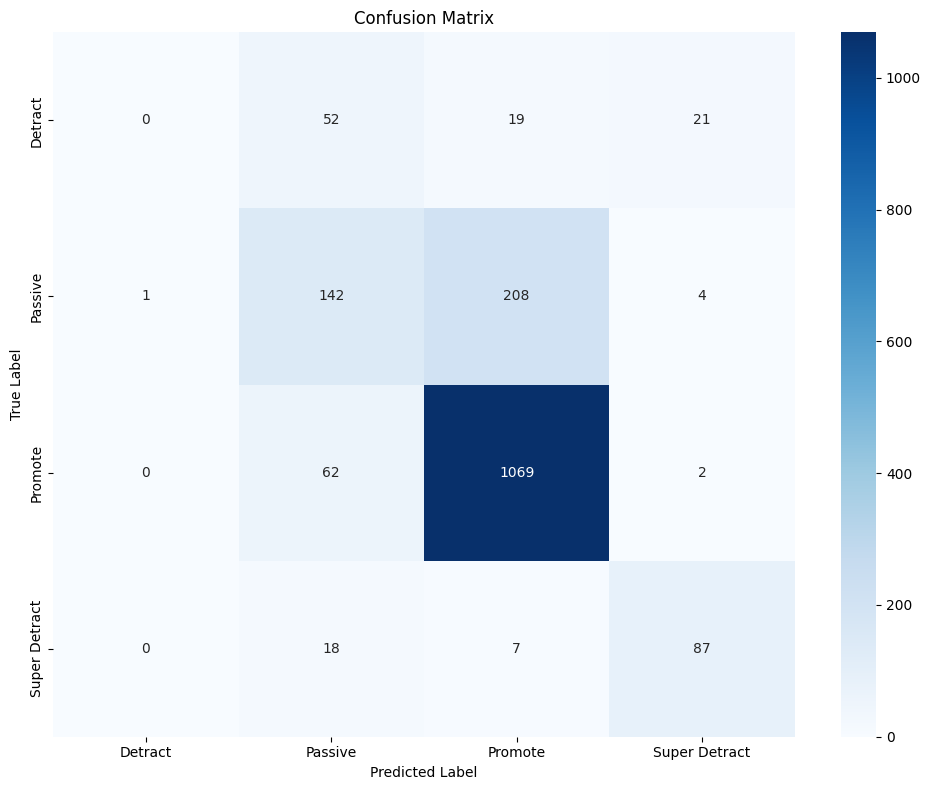

In [3]:
# Get predictions
predictions = result.predict(X_test_with_const)
predicted_classes = predictions.idxmax(axis=1)

# Calculate and print classification metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\nClassification Report:")
print(classification_report(y_test, predicted_classes))

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Detract', 'Passive', 'Promote', 'Super Detract'],
            yticklabels=['Detract', 'Passive', 'Promote', 'Super Detract'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

class RecommendationAnalysis:
    def __init__(self):
        self.numeric_features = [
            'iag_trust_confidence_scale11',
            'iag_value_price_of_policy_reflects_scale11'
        ]
        self.categorical_features = [
            'iag_business_unit_ug',
            'iag_age_band_auto',
            'iag_tenure_band_enum',
            'iag_product_type_auto',
            'iag_region_ug'
        ]
        self.selected_features = None  # Store selected features
    
    def prepare_data(self, df):
        print("\nStarting data preparation...")
        
        # Drop missing values
        features = self.numeric_features + self.categorical_features
        df_clean = df.dropna(subset=features + ['Likely to recommend']).copy()
        
        # Scale numeric features
        scaler = StandardScaler()
        df_clean[self.numeric_features] = scaler.fit_transform(df_clean[self.numeric_features])
        
        # Create dummy variables
        X_categorical = pd.get_dummies(df_clean[self.categorical_features], 
                                     drop_first=True, 
                                     dummy_na=False)
        
        # Combine features
        X = pd.concat([df_clean[self.numeric_features], X_categorical], axis=1)
        
        # Ensure all features are float64
        X = X.astype(np.float64)
        
        # Add constant
        X = sm.add_constant(X)
        X = X.astype(np.float64)
        
        # Convert target to binary (Promote vs Others)
        y = (df_clean['Likely to recommend'] == 'Promote').astype(np.int64)
        
        return X, y, df_clean
    
    def check_collinearity(self, X):
        """Check and handle collinearity"""
        # Calculate correlation matrix
        corr_matrix = X.corr().abs()
        
        # Find highly correlated pairs
        high_corr_pairs = []
        cols_to_drop = set()
        
        for i, col1 in enumerate(corr_matrix.columns):
            for j, col2 in enumerate(corr_matrix.columns[i+1:], i+1):
                if corr_matrix.iloc[i, j] > 0.7 and col1 != 'const':
                    high_corr_pairs.append((col1, col2, corr_matrix.iloc[i, j]))
                    cols_to_drop.add(col2)  # Drop the second of each pair
        
        print(f"\nFound {len(high_corr_pairs)} highly correlated pairs")
        if high_corr_pairs:
            print("Sample correlated pairs:")
            for col1, col2, corr in high_corr_pairs[:5]:
                print(f"{col1} -- {col2}: {corr:.3f}")
        
        return list(cols_to_drop)
    
    def fit_model(self, X, y):
        try:
            # Remove highly correlated features
            cols_to_drop = self.check_collinearity(X)
            if cols_to_drop:
                X = X.drop(columns=cols_to_drop)
                print(f"\nRemoved {len(cols_to_drop)} collinear features")
            
            # Store selected features for prediction
            self.selected_features = X.columns
            
            # Convert to numpy arrays
            X_np = X.to_numpy(dtype=np.float64)
            y_np = y.to_numpy(dtype=np.int64)
            
            print(f"\nFinal feature matrix shape: {X_np.shape}")
            print(f"Feature matrix dtype: {X_np.dtype}")
            print(f"Target vector dtype: {y_np.dtype}")
            
            # Try different optimization methods
            methods = ['newton', 'bfgs', 'lbfgs']
            for method in methods:
                try:
                    print(f"\nTrying {method} optimization...")
                    model = sm.Logit(y_np, X_np)
                    results = model.fit(method=method, maxiter=1000)
                    
                    if hasattr(results, 'mle_retvals') and \
                       'converged' in results.mle_retvals and \
                       not results.mle_retvals['converged']:
                        print(f"{method} did not converge, trying next method...")
                        continue
                    
                    return results
                except Exception as e:
                    print(f"{method} optimization failed: {str(e)}")
                    continue
            
            raise Exception("All optimization methods failed")
            
        except Exception as e:
            print(f"Model fitting failed: {str(e)}")
            return None
    
    def analyze(self, df):
        X, y, df_clean = self.prepare_data(df)
        results = self.fit_model(X, y)
        
        if results is not None and self.selected_features is not None:
            # Create summary DataFrame
            summary_df = pd.DataFrame({
                'Feature': self.selected_features,
                'Coefficient': results.params,
                'P_Value': results.pvalues,
                'Odds_Ratio': np.exp(results.params)
            })
            summary_df = summary_df.sort_values('P_Value')
            
            # Calculate predictions using only selected features
            X_pred = X[self.selected_features]
            X_np = X_pred.to_numpy(dtype=np.float64)
            y_pred = results.predict(X_np)
            y_pred_binary = (y_pred > 0.5).astype(int)
            
            # Calculate metrics
            metrics = {
                'accuracy': (y_pred_binary == y).mean(),
                'roc_auc': roc_auc_score(y, y_pred),
                'classification_report': classification_report(y, y_pred_binary, output_dict=True),
                'pseudo_r2': results.prsquared
            }
            
            return {
                'feature_importance': summary_df,
                'metrics': metrics,
                'model': results
            }
        return None

# Run analysis
print("Loading data...")
df = pd.read_excel('../../data/IAG.xlsx')
analyzer = RecommendationAnalysis()
results = analyzer.analyze(df)

if results:
    print("\nModel Summary:")
    
    print("\nSignificant Features (p < 0.05):")
    significant_features = results['feature_importance'][results['feature_importance']['P_Value'] < 0.05]
    print(significant_features[['Feature', 'Coefficient', 'P_Value', 'Odds_Ratio']])
    
    print("\nModel Performance:")
    metrics = results['metrics']
    print(f"Accuracy: {metrics['accuracy']:.3f}")
    print(f"ROC AUC: {metrics['roc_auc']:.3f}")
    print(f"McFadden's Pseudo R-squared: {metrics['pseudo_r2']:.3f}")
    
    print("\nClassification Report:")
    cls_report = pd.DataFrame(metrics['classification_report']).transpose()
    print(cls_report)
else:
    print("Model fitting failed. Please check the error messages above.")

Loading data...

Starting data preparation...

Found 2 highly correlated pairs
Sample correlated pairs:
iag_trust_confidence_scale11 -- iag_value_price_of_policy_reflects_scale11: 0.780
iag_product_type_auto_Homeowners Line -- iag_product_type_auto_Private Motor Line: 0.723

Removed 2 collinear features

Final feature matrix shape: (8457, 24)
Feature matrix dtype: float64
Target vector dtype: int64

Trying newton optimization...
Optimization terminated successfully.
         Current function value: 0.407849
         Iterations 525
newton optimization failed: Singular matrix

Trying bfgs optimization...
Optimization terminated successfully.
         Current function value: 0.407851
         Iterations: 211
         Function evaluations: 212
         Gradient evaluations: 212

Model Summary:

Significant Features (p < 0.05):
                              Feature  Coefficient       P_Value  Odds_Ratio
1        iag_trust_confidence_scale11     2.370548  0.000000e+00   10.703252
22  iag_reg

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

class RecommendationAnalysis:
    def __init__(self):
        self.numeric_features = [
            'iag_trust_confidence_scale11',
            'iag_value_price_of_policy_reflects_scale11'
        ]
        self.categorical_features = [
            'iag_business_unit_ug',
            'iag_age_band_auto',
            'iag_tenure_band_enum',
            'iag_product_type_auto',
            'iag_region_ug'
        ]
    
    def prepare_data(self, df):
        print("\nStarting data preparation...")
        
        # Drop missing values
        features = self.numeric_features + self.categorical_features
        df_clean = df.dropna(subset=features + ['Likely to recommend']).copy()
        
        # Scale numeric features
        scaler = StandardScaler()
        df_clean[self.numeric_features] = scaler.fit_transform(df_clean[self.numeric_features])
        
        # Create dummy variables
        X_categorical = pd.get_dummies(df_clean[self.categorical_features], 
                                     drop_first=True, 
                                     dummy_na=False)
        
        print("\nCreated dummy variables:")
        for col in X_categorical.columns:
            print(f"- {col}")
        
        # Combine features
        X = pd.concat([df_clean[self.numeric_features], X_categorical], axis=1)
        print("\nAll features after combining numeric and categorical:")
        for col in X.columns:
            print(f"- {col}")
        
        # Ensure all features are float64
        X = X.astype(np.float64)
        
        # Add constant
        X = sm.add_constant(X)
        X = X.astype(np.float64)
        
        # Convert target to binary (Promote vs Others)
        y = (df_clean['Likely to recommend'] == 'Promote').astype(np.int64)
        
        return X, y, df_clean
    
    def check_collinearity(self, X):
        """Check and handle collinearity"""
        # Calculate correlation matrix
        corr_matrix = X.corr().abs()
        
        # Find highly correlated pairs
        high_corr_pairs = []
        cols_to_drop = set()
        
        for i, col1 in enumerate(corr_matrix.columns):
            for j, col2 in enumerate(corr_matrix.columns[i+1:], i+1):
                if corr_matrix.iloc[i, j] > 0.7 and col1 != 'const':
                    high_corr_pairs.append((col1, col2, corr_matrix.iloc[i, j]))
                    cols_to_drop.add(col2)  # Drop the second of each pair
        
        print(f"\nFound {len(high_corr_pairs)} highly correlated pairs:")
        for col1, col2, corr in high_corr_pairs:
            print(f"- {col1} -- {col2}: {corr:.3f}")
        
        print("\nFeatures to be dropped due to collinearity:")
        for col in cols_to_drop:
            print(f"- {col}")
        
        return list(cols_to_drop)
    
    def fit_model(self, X, y):
        try:
            # Remove highly correlated features
            cols_to_drop = self.check_collinearity(X)
            if cols_to_drop:
                X = X.drop(columns=cols_to_drop)
                print(f"\nRemaining features after removing collinearity:")
                for col in X.columns:
                    print(f"- {col}")
            
            # Store selected features for prediction
            self.selected_features = X.columns
            
            # Convert to numpy arrays
            X_np = X.to_numpy(dtype=np.float64)
            y_np = y.to_numpy(dtype=np.int64)
            
            print(f"\nFinal feature matrix shape: {X_np.shape}")
            
            # Try different optimization methods
            methods = ['newton', 'bfgs', 'lbfgs']
            for method in methods:
                try:
                    print(f"\nTrying {method} optimization...")
                    model = sm.Logit(y_np, X_np)
                    results = model.fit(method=method, maxiter=1000)
                    
                    if hasattr(results, 'mle_retvals') and \
                       'converged' in results.mle_retvals and \
                       not results.mle_retvals['converged']:
                        print(f"{method} did not converge, trying next method...")
                        continue
                    
                    return results
                except Exception as e:
                    print(f"{method} optimization failed: {str(e)}")
                    continue
            
            raise Exception("All optimization methods failed")
            
        except Exception as e:
            print(f"Model fitting failed: {str(e)}")
            return None

    def analyze(self, df):
        X, y, df_clean = self.prepare_data(df)
        results = self.fit_model(X, y)
        
        if results is not None and self.selected_features is not None:
            # Create summary DataFrame with all coefficients
            summary_df = pd.DataFrame({
                'Feature': self.selected_features,
                'Coefficient': results.params,
                'P_Value': results.pvalues,
                'Odds_Ratio': np.exp(results.params)
            })
            summary_df = summary_df.sort_values('P_Value')
            
            # Calculate predictions using only selected features
            X_pred = X[self.selected_features]
            X_np = X_pred.to_numpy(dtype=np.float64)
            y_pred = results.predict(X_np)
            y_pred_binary = (y_pred > 0.5).astype(int)
            
            # Calculate metrics
            metrics = {
                'accuracy': (y_pred_binary == y).mean(),
                'roc_auc': roc_auc_score(y, y_pred),
                'classification_report': classification_report(y, y_pred_binary, output_dict=True),
                'pseudo_r2': results.prsquared
            }
            
            return {
                'feature_importance': summary_df,
                'metrics': metrics,
                'model': results
            }
        return None

# Run analysis
print("Loading data...")
df = pd.read_excel('../../data/IAG.xlsx')
analyzer = RecommendationAnalysis()
results = analyzer.analyze(df)

if results:
    print("\nModel Summary:")
    
    print("\nAll Features and their Coefficients:")
    feature_importance = results['feature_importance']
    print(feature_importance[['Feature', 'Coefficient', 'P_Value', 'Odds_Ratio']])
    
    print("\nModel Performance:")
    metrics = results['metrics']
    print(f"Accuracy: {metrics['accuracy']:.3f}")
    print(f"ROC AUC: {metrics['roc_auc']:.3f}")
    print(f"McFadden's Pseudo R-squared: {metrics['pseudo_r2']:.3f}")
    
    print("\nClassification Report:")
    cls_report = pd.DataFrame(metrics['classification_report']).transpose()
    print(cls_report)
else:
    print("Model fitting failed. Please check the error messages above.")

Loading data...

Starting data preparation...

Created dummy variables:
- iag_business_unit_ug_Operations
- iag_age_band_auto_25-34
- iag_age_band_auto_35-44
- iag_age_band_auto_45-54
- iag_age_band_auto_55-64
- iag_age_band_auto_65+
- iag_tenure_band_enum_11-20
- iag_tenure_band_enum_21-30
- iag_tenure_band_enum_3-5
- iag_tenure_band_enum_30+
- iag_tenure_band_enum_6-10
- iag_tenure_band_enum_<1
- iag_product_type_auto_EasyRider
- iag_product_type_auto_Home
- iag_product_type_auto_Home Pack
- iag_product_type_auto_Homeowners Line
- iag_product_type_auto_Jetsetter
- iag_product_type_auto_Landlord
- iag_product_type_auto_Private Motor Line
- iag_product_type_auto_Vehicle
- iag_product_type_auto_Wheels
- iag_region_ug_Consumer Claims Ops
- iag_region_ug_Retail Network Claims

All features after combining numeric and categorical:
- iag_trust_confidence_scale11
- iag_value_price_of_policy_reflects_scale11
- iag_business_unit_ug_Operations
- iag_age_band_auto_25-34
- iag_age_band_auto_35-44

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import classification_report, roc_auc_score

class RecommendationAnalysis:
    def __init__(self):
        self.trust_bins = [-np.inf, 5, 7, 8, 9, np.inf]
        self.trust_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
        
        self.price_bins = [-np.inf, 5, 6, 7, 8, np.inf]
        self.price_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
        
        self.features = [
            'iag_trust_confidence_scale11',
            'iag_value_price_of_policy_reflects_scale11',
            'iag_business_unit_ug',
            'iag_age_band_auto',
            'iag_tenure_band_enum',
            'iag_product_type_auto',
            'iag_region_ug'
        ]
    
    def prepare_data(self, df):
        print("\nStarting data preparation...")
        
        # Create copy and drop missing values
        df_clean = df.copy()
        df_clean = df_clean.dropna(subset=self.features + ['Likely to recommend'])
        
        print("\nShape after dropping missing values:", df_clean.shape)
        
        # Create binned versions of numeric features
        df_clean['iag_trust_confidence_binned'] = pd.cut(
            df_clean['iag_trust_confidence_scale11'].astype(float),
            bins=self.trust_bins,
            labels=self.trust_labels
        )
        
        df_clean['iag_value_price_binned'] = pd.cut(
            df_clean['iag_value_price_of_policy_reflects_scale11'].astype(float),
            bins=self.price_bins,
            labels=self.price_labels
        )
        
        print("\nUnique values in binned features:")
        print("Trust bins:", df_clean['iag_trust_confidence_binned'].value_counts())
        print("\nPrice bins:", df_clean['iag_value_price_binned'].value_counts())
        
        # Define categorical features including binned ones
        categorical_features = [
            'iag_trust_confidence_binned',
            'iag_value_price_binned',
            'iag_business_unit_ug',
            'iag_age_band_auto',
            'iag_tenure_band_enum',
            'iag_product_type_auto',
            'iag_region_ug'
        ]
        
        # Create dummies with proper prefixes
        X = pd.get_dummies(df_clean[categorical_features], drop_first=True)
        
        print("\nDummy variables created:", X.shape[1])
        print("Sample column names:", list(X.columns)[:5])
        
        # Convert all columns to float64
        X = X.astype(np.float64)
        
        # Add constant
        X = sm.add_constant(X)
        
        # Convert target to binary
        y = (df_clean['Likely to recommend'] == 'Promote').astype(np.int64)
        
        print("\nFeature matrix shape:", X.shape)
        print("Feature matrix dtype:", X.dtypes.unique())
        print("Target vector shape:", y.shape)
        print("Target distribution:\n", y.value_counts())
        
        return X, y, df_clean
    
    def fit_model(self, X, y):
        try:
            print(f"\nFitting model with {X.shape[1]} features...")
            
            # Convert to numpy arrays
            X_np = X.to_numpy(dtype=np.float64)
            y_np = y.to_numpy(dtype=np.int64)
            
            print("X shape:", X_np.shape)
            print("y shape:", y_np.shape)
            print("X dtype:", X_np.dtype)
            print("y dtype:", y_np.dtype)
            
            # Fit model
            model = sm.Logit(y_np, X_np)
            results = model.fit(method='bfgs', maxiter=1000)
            
            return results
            
        except Exception as e:
            print(f"Model fitting failed: {str(e)}")
            if isinstance(X, pd.DataFrame):
                print("\nFeature names:", X.columns.tolist())
                print("\nSample data:")
                print(X.head())
            return None
    
    def analyze(self, df):
        X, y, df_clean = self.prepare_data(df)
        results = self.fit_model(X, y)
        
        if results is not None:
            # Calculate predictions
            X_np = X.to_numpy(dtype=np.float64)
            y_pred = results.predict(X_np)
            y_pred_binary = (y_pred > 0.5).astype(int)
            
            # Create summary DataFrame
            summary_df = pd.DataFrame({
                'Feature': X.columns,
                'Coefficient': results.params,
                'P_Value': results.pvalues,
                'Odds_Ratio': np.exp(results.params)
            }).sort_values('P_Value')
            
            # Calculate metrics
            metrics = {
                'accuracy': (y_pred_binary == y).mean(),
                'roc_auc': roc_auc_score(y, y_pred),
                'classification_report': classification_report(y, y_pred_binary, output_dict=True),
                'pseudo_r2': results.prsquared
            }
            
            return {
                'feature_importance': summary_df,
                'metrics': metrics,
                'model': results
            }
        return None

# Run analysis
print("Loading data...")
df = pd.read_excel('../../data/IAG.xlsx')

print("\nOriginal data shape:", df.shape)
print("\nColumn types:")
print(df[['iag_trust_confidence_scale11', 
         'iag_value_price_of_policy_reflects_scale11', 
         'Likely to recommend']].dtypes)

analyzer = RecommendationAnalysis()
results = analyzer.analyze(df)

if results:
    print("\nModel Summary:")
    
    print("\nSignificant Features (p < 0.05):")
    significant_features = results['feature_importance'][
        results['feature_importance']['P_Value'] < 0.05
    ]
    print(significant_features[['Feature', 'Coefficient', 'P_Value', 'Odds_Ratio']])
    
    print("\nModel Performance:")
    metrics = results['metrics']
    print(f"Accuracy: {metrics['accuracy']:.3f}")
    print(f"ROC AUC: {metrics['roc_auc']:.3f}")
    print(f"McFadden's Pseudo R-squared: {metrics['pseudo_r2']:.3f}")
else:
    print("Model fitting failed. Please check the error messages above.")

Loading data...

Original data shape: (9264, 48)

Column types:
iag_trust_confidence_scale11                  float64
iag_value_price_of_policy_reflects_scale11    float64
Likely to recommend                            object
dtype: object

Starting data preparation...

Shape after dropping missing values: (8457, 48)

Unique values in binned features:
Trust bins: iag_trust_confidence_binned
Very High    3645
High         1551
Moderate     1435
Low           972
Very Low      854
Name: count, dtype: int64

Price bins: iag_value_price_binned
Excellent    4065
Very Good    1639
Poor         1154
Good         1040
Fair          559
Name: count, dtype: int64

Dummy variables created: 31
Sample column names: ['iag_trust_confidence_binned_Low', 'iag_trust_confidence_binned_Moderate', 'iag_trust_confidence_binned_High', 'iag_trust_confidence_binned_Very High', 'iag_value_price_binned_Fair']

Feature matrix shape: (8457, 32)
Feature matrix dtype: [dtype('float64')]
Target vector shape: (8457,)


Model Performance:

Test Accuracy: 0.7653664302600472

Classification Report:
               precision    recall  f1-score   support

      Detract       0.20      0.01      0.02        92
      Passive       0.52      0.38      0.44       355
      Promote       0.81      0.95      0.88      1133
Super Detract       0.76      0.78      0.77       112

     accuracy                           0.77      1692
    macro avg       0.58      0.53      0.53      1692
 weighted avg       0.72      0.77      0.73      1692


Feature Importance for each class:

Class: Detract
                                  Feature  Coefficient
15             iag_product_type_auto_Home     0.581401
0            iag_trust_confidence_scale11    -0.579054
22           iag_product_type_auto_Wheels     0.510256
6                 iag_age_band_auto_55-64    -0.449060
4                 iag_age_band_auto_35-44    -0.386896
5                 iag_age_band_auto_45-54    -0.377738
7                   iag_age_band_auto_65+ 

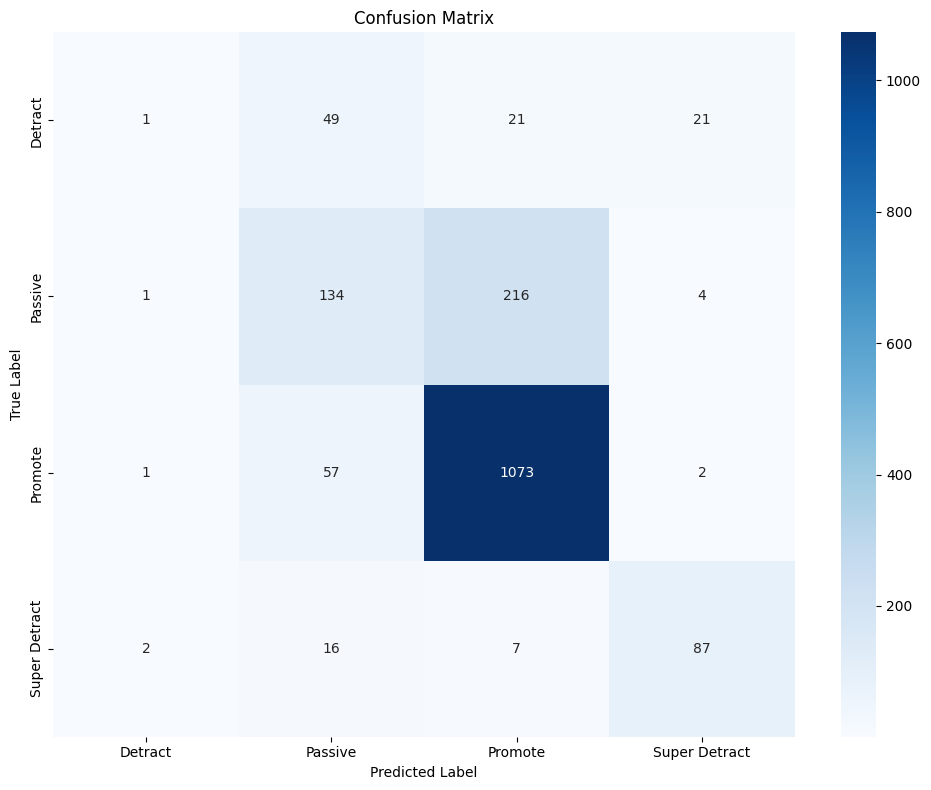

e:\Apps\anaconda3\envs\iag\lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
e:\Apps\anaconda3\envs\iag\lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Cross-validation scores: [0.75059102 0.75768322 0.75694855 0.76227085 0.76759314]
Mean CV score: 0.7590173537277731
Standard deviation: 0.005677893107213202


In [10]:
# using sklearn logistic regression

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Read the data
df = pd.read_excel('../../data/IAG.xlsx')

# Define features
categorical_features = [
    'iag_business_unit_ug',
    'iag_age_band_auto',
    'iag_tenure_band_enum',
    'iag_product_type_auto',
    'iag_region_ug'
]

numeric_features = [
    'iag_trust_confidence_scale11',
    'iag_value_price_of_policy_reflects_scale11'
]

# Drop rows with missing values in target and features
features_to_check = numeric_features + categorical_features
df_clean = df.dropna(subset=features_to_check + ['Likely to recommend']).copy()

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine transformers
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    verbose_feature_names_out=False
)

# Create full pipeline including the model
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        multi_class='multinomial',
        max_iter=1000,
        solver='lbfgs',
        random_state=42
    ))
])

# Prepare X and y
X = df_clean[features_to_check]
y = df_clean['Likely to recommend']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit the pipeline
model_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = model_pipeline.predict(X_test)

# Print model performance
print("Model Performance:\n")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Get and display feature coefficients
coefficients = model_pipeline.named_steps['classifier'].coef_
classes = model_pipeline.named_steps['classifier'].classes_

print("\nFeature Importance for each class:")
for idx, class_name in enumerate(classes):
    print(f"\nClass: {class_name}")
    feat_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients[idx]
    })
    feat_importance = feat_importance.sort_values('Coefficient', key=abs, ascending=False)
    print(feat_importance.head(10))  # Show top 10 most important features

# Additional model evaluation
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print cross-validation scores
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model_pipeline, X, y, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE

class NumericFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.trust_bins = [-np.inf, 5, 7, 8, 9, np.inf]
        self.price_bins = [-np.inf, 5, 6, 7, 8, np.inf]
        self.scaler = StandardScaler()
        
    def fit(self, X, y=None):
        # Convert DataFrame to numpy array if necessary
        X_array = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        self.scaler.fit(X_array)
        return self
    
    def transform(self, X):
        # Convert DataFrame to numpy array if necessary
        X_array = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        
        # Create binned features
        trust_binned = pd.cut(X_array[:, 0], bins=self.trust_bins, labels=False)
        price_binned = pd.cut(X_array[:, 1], bins=self.price_bins, labels=False)
        
        # Create interaction and polynomial features
        trust_price_interaction = X_array[:, 0] * X_array[:, 1]
        trust_squared = X_array[:, 0] ** 2
        price_squared = X_array[:, 1] ** 2
        
        # Scale original features
        X_scaled = self.scaler.transform(X_array)
        
        # Combine all features
        return np.column_stack([
            X_scaled,  # 2 columns
            trust_binned.reshape(-1, 1),  # 1 column
            price_binned.reshape(-1, 1),  # 1 column
            trust_price_interaction.reshape(-1, 1),  # 1 column
            trust_squared.reshape(-1, 1),  # 1 column
            price_squared.reshape(-1, 1)  # 1 column
        ])
    
    def get_feature_names_out(self, feature_names=None):
        if feature_names is None:
            feature_names = ['trust', 'price']
            
        scaled_names = [f"{name}_scaled" for name in feature_names]
        binned_names = [f"{name}_binned" for name in feature_names]
        interaction_names = ['trust_price_interaction']
        squared_names = [f"{name}_squared" for name in feature_names]
        
        return np.array(scaled_names + binned_names + interaction_names + squared_names)

# Read and prepare data
df = pd.read_excel('../../data/IAG.xlsx')

categorical_features = [
    'iag_business_unit_ug',
    'iag_age_band_auto',
    'iag_tenure_band_enum',
    'iag_product_type_auto',
    'iag_region_ug'
]

numeric_features = [
    'iag_trust_confidence_scale11',
    'iag_value_price_of_policy_reflects_scale11'
]

# Drop rows with missing values
features_to_check = numeric_features + categorical_features
df_clean = df.dropna(subset=features_to_check + ['Likely to recommend']).copy()

# Create preprocessing pipelines
numeric_transformer = NumericFeatureTransformer()

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine transformers
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features)
)

# Prepare X and y
X = df_clean[features_to_check]
y = df_clean['Likely to recommend']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Get feature names
numeric_feature_names = list(numeric_transformer.get_feature_names_out(numeric_features))
categorical_feature_names = [
    f"{feat}_{val}" for feat in categorical_features 
    for val in df_clean[feat].unique()[1:]
]
feature_names = numeric_feature_names + categorical_feature_names

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)

# Fit the classifier
classifier = LogisticRegression(
    multi_class='multinomial',
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs',
    random_state=42
)
classifier.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = classifier.predict(X_test_transformed)

# Print performance metrics
print("Model Performance:\n")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display feature importance
print("\nFeature Importance for each class:")
for idx, class_name in enumerate(classifier.classes_):
    print(f"\nClass: {class_name}")
    feat_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': classifier.coef_[idx]
    })
    feat_importance = feat_importance.sort_values('Coefficient', key=abs, ascending=False)
    print(feat_importance.head(10))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(pd.DataFrame(
    cm,
    index=[f'True {c}' for c in classifier.classes_],
    columns=[f'Pred {c}' for c in classifier.classes_]
))

# Print class distributions
print("\nOriginal class distribution:")
print(pd.Series(y_train).value_counts())
print("\nBalanced class distribution:")
print(pd.Series(y_train_balanced).value_counts())

# Calculate cross-validation scores
cv_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        multi_class='multinomial',
        max_iter=1000,
        class_weight='balanced',
        solver='lbfgs',
        random_state=42
    ))
])

cv_scores = cross_val_score(cv_pipeline, X, y, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())

e:\Apps\anaconda3\envs\iag\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Performance:

Test Accuracy: 0.710401891252955

Classification Report:
               precision    recall  f1-score   support

      Detract       0.25      0.49      0.33        92
      Passive       0.44      0.57      0.50       355
      Promote       0.93      0.76      0.84      1133
Super Detract       0.74      0.78      0.76       112

     accuracy                           0.71      1692
    macro avg       0.59      0.65      0.61      1692
 weighted avg       0.78      0.71      0.73      1692


Feature Importance for each class:

Class: Detract
                                              Feature  Coefficient
20           iag_product_type_auto_Private Motor Line     1.140395
1   iag_value_price_of_policy_reflects_scale11_scaled    -0.615165
11                            iag_age_band_auto_25-34    -0.609203
7                       iag_business_unit_ug_Consumer     0.591490
9                               iag_age_band_auto_65+    -0.557882
10                        

e:\Apps\anaconda3\envs\iag\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\Apps\anaconda3\envs\iag\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i


Cross-validation scores: [0.68321513 0.70330969 0.70136014 0.70490834 0.73447664]
Mean CV score: 0.7054539887850153
Standard deviation: 0.016483546374342767


e:\Apps\anaconda3\envs\iag\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

class EnhancedNumericTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.trust_bins = [-np.inf, 5, 7, 8, 9, np.inf]
        self.price_bins = [-np.inf, 5, 6, 7, 8, np.inf]
        self.power_transformer = PowerTransformer(method='yeo-johnson')
        self.scaler = StandardScaler()
        
    def fit(self, X, y=None):
        X_array = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        self.power_transformer.fit(X_array)
        X_power = self.power_transformer.transform(X_array)
        self.scaler.fit(X_power)
        return self
    
    def transform(self, X):
        X_array = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        X_power = self.power_transformer.transform(X_array)
        X_scaled = self.scaler.transform(X_power)
        
        # Create binned features
        trust_binned = pd.cut(X_array[:, 0], bins=self.trust_bins, labels=False)
        price_binned = pd.cut(X_array[:, 1], bins=self.price_bins, labels=False)
        
        # Create interaction features
        trust_price_interaction = X_scaled[:, 0] * X_scaled[:, 1]
        trust_squared = X_scaled[:, 0] ** 2
        price_squared = X_scaled[:, 1] ** 2
        trust_cubed = X_scaled[:, 0] ** 3
        price_cubed = X_scaled[:, 1] ** 3
        
        # Create threshold-based features
        high_trust = (X_array[:, 0] > 8).astype(float)
        high_price = (X_array[:, 1] > 7).astype(float)
        low_trust = (X_array[:, 0] < 6).astype(float)
        low_price = (X_array[:, 1] < 5).astype(float)
        
        # Scale all engineered features
        engineered_features = np.column_stack([
            trust_price_interaction,
            trust_squared,
            price_squared,
            trust_cubed,
            price_cubed,
            high_trust,
            high_price,
            low_trust,
            low_price
        ])
        engineered_scaler = StandardScaler()
        engineered_scaled = engineered_scaler.fit_transform(engineered_features)
        
        return np.column_stack([
            X_scaled,  # Original scaled features (2)
            trust_binned.reshape(-1, 1),  # Binned features (2)
            price_binned.reshape(-1, 1),
            engineered_scaled  # Engineered features (9)
        ])
    
    def get_feature_names_out(self, feature_names=None):
        if feature_names is None:
            feature_names = ['trust', 'price']
        
        scaled_names = [f"{name}_scaled" for name in feature_names]
        binned_names = [f"{name}_binned" for name in feature_names]
        engineered_names = [
            'trust_price_interaction',
            'trust_squared',
            'price_squared',
            'trust_cubed',
            'price_cubed',
            'high_trust',
            'high_price',
            'low_trust',
            'low_price'
        ]
        return np.array(scaled_names + binned_names + engineered_names)

# Read and prepare data
df = pd.read_excel('../../data/IAG.xlsx')

categorical_features = [
    'iag_business_unit_ug',
    'iag_age_band_auto',
    'iag_tenure_band_enum',
    'iag_product_type_auto',
    'iag_region_ug'
]

numeric_features = [
    'iag_trust_confidence_scale11',
    'iag_value_price_of_policy_reflects_scale11'
]

# Drop rows with missing values
features_to_check = numeric_features + categorical_features
df_clean = df.dropna(subset=features_to_check + ['Likely to recommend']).copy()

# Create preprocessing pipelines
numeric_transformer = EnhancedNumericTransformer()

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine transformers
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features)
)

# Prepare X and y
X = df_clean[features_to_check]
y = df_clean['Likely to recommend']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Calculate target class distribution
class_counts = y_train.value_counts()
n_samples_majority = class_counts.max()

# Configure SMOTE for balanced but not completely equal classes
sampling_strategy = {
    'Detract': min(n_samples_majority, int(n_samples_majority * 0.8)),
    'Passive': min(n_samples_majority, int(n_samples_majority * 0.9)),
    'Super Detract': min(n_samples_majority, int(n_samples_majority * 0.8))
}

# Apply SMOTE
smote = SMOTE(
    random_state=42,
    sampling_strategy=sampling_strategy
)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)

# Feature selection with increased max_iter
selector = SelectFromModel(
    LogisticRegression(
        multi_class='multinomial',
        max_iter=3000,
        class_weight='balanced',
        C=0.1
    ),
    max_features=30
)

# Fit selector and transform data
X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
X_test_selected = selector.transform(X_test_transformed)

# Final classifier with tuned parameters
classifier = LogisticRegression(
    multi_class='multinomial',
    max_iter=3000,
    class_weight='balanced',
    solver='saga',  # Changed to saga for better convergence
    random_state=42,
    tol=1e-4,
    C=0.1
)

# Fit the classifier
classifier.fit(X_train_selected, y_train_balanced)

# Make predictions
y_pred = classifier.predict(X_test_selected)

# Print performance metrics
print("Model Performance:\n")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(pd.DataFrame(
    cm,
    index=[f'True {c}' for c in classifier.classes_],
    columns=[f'Pred {c}' for c in classifier.classes_]
))

# Print class distributions
print("\nOriginal class distribution:")
print(pd.Series(y_train).value_counts())
print("\nBalanced class distribution:")
print(pd.Series(y_train_balanced).value_counts())

Model Performance:

Test Accuracy: 0.7204491725768322

Classification Report:
               precision    recall  f1-score   support

      Detract       0.27      0.45      0.34        92
      Passive       0.46      0.65      0.54       355
      Promote       0.93      0.76      0.84      1133
Super Detract       0.75      0.79      0.77       112

     accuracy                           0.72      1692
    macro avg       0.60      0.66      0.62      1692
 weighted avg       0.78      0.72      0.74      1692


Confusion Matrix:
                    Pred Detract  Pred Passive  Pred Promote  \
True Detract                  41            26             4   
True Passive                  65           229            56   
True Promote                  31           238           861   
True Super Detract            14             6             4   

                    Pred Super Detract  
True Detract                        21  
True Passive                         5  
True Promote    

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE

class DomainFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.trust_bins = [-np.inf, 5, 7, 8, 9, np.inf]
        self.price_bins = [-np.inf, 5, 6, 7, 8, np.inf]
        self.power_transformer = PowerTransformer(method='yeo-johnson')
        self.scaler = StandardScaler()
        
    def fit(self, X, y=None):
        X_array = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        self.power_transformer.fit(X_array)
        X_power = self.power_transformer.transform(X_array)
        self.scaler.fit(X_power)
        return self
    
    def transform(self, X):
        X_array = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        X_power = self.power_transformer.transform(X_array)
        X_scaled = self.scaler.transform(X_power)
        
        trust_scores = X_array[:, 0]
        price_scores = X_array[:, 1]
        
        # Domain-specific feature engineering
        very_satisfied = (trust_scores >= 9) & (price_scores >= 8)
        very_dissatisfied = (trust_scores <= 5) & (price_scores <= 5)
        mixed_experience = np.abs(trust_scores - price_scores) >= 3
        
        # Create satisfaction segments
        high_trust_low_price = (trust_scores >= 8) & (price_scores <= 6)
        low_trust_high_price = (trust_scores <= 6) & (price_scores >= 8)
        
        # Relative satisfaction metrics
        trust_to_price_ratio = trust_scores / (price_scores + 1)  # Add 1 to avoid division by zero
        satisfaction_gap = trust_scores - price_scores
        
        # Combined satisfaction score
        combined_score = (trust_scores * 0.6 + price_scores * 0.4)  # Weighted average
        
        # Create the feature matrix
        features = np.column_stack([
            X_scaled,
            very_satisfied,
            very_dissatisfied,
            mixed_experience,
            high_trust_low_price,
            low_trust_high_price,
            trust_to_price_ratio.reshape(-1, 1),
            satisfaction_gap.reshape(-1, 1),
            combined_score.reshape(-1, 1)
        ])
        
        return features
    
    def get_feature_names_out(self, feature_names=None):
        base_names = ['trust_scaled', 'price_scaled']
        engineered_names = [
            'very_satisfied',
            'very_dissatisfied',
            'mixed_experience',
            'high_trust_low_price',
            'low_trust_high_price',
            'trust_price_ratio',
            'satisfaction_gap',
            'combined_score'
        ]
        return np.array(base_names + engineered_names)

def train_and_evaluate_model(df_path='../../data/IAG.xlsx'):
    # Read and prepare data
    df = pd.read_excel(df_path)
    
    categorical_features = [
        'iag_business_unit_ug',
        'iag_age_band_auto',
        'iag_tenure_band_enum',
        'iag_product_type_auto',
        'iag_region_ug'
    ]

    numeric_features = [
        'iag_trust_confidence_scale11',
        'iag_value_price_of_policy_reflects_scale11'
    ]

    # Drop rows with missing values
    features_to_check = numeric_features + categorical_features
    df_clean = df.dropna(subset=features_to_check + ['Likely to recommend']).copy()

    # Create preprocessing pipelines
    numeric_transformer = DomainFeatureTransformer()

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    # Combine transformers
    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features)
    )

    # Prepare X and y
    X = df_clean[features_to_check]
    y = df_clean['Likely to recommend']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Transform the data
    print("Transforming features...")
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    print("Transformed training data shape:", X_train_transformed.shape)

    # Calculate custom class weights
    class_counts = y_train.value_counts()
    total_samples = len(y_train)
    class_weights = {
        cls: (total_samples / (len(class_counts) * count)) ** 0.5
        for cls, count in class_counts.items()
    }

    # Configure SMOTE with moderate balancing
    sampling_strategy = {
        'Detract': int(class_counts['Promote'] * 0.7),
        'Passive': int(class_counts['Promote'] * 0.8),
        'Super Detract': int(class_counts['Promote'] * 0.7)
    }

    # Apply SMOTE
    print("Applying SMOTE...")
    smote = SMOTE(
        random_state=42,
        sampling_strategy=sampling_strategy
    )
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)
    print("Balanced training data shape:", X_train_balanced.shape)

    # Feature selection
    print("Performing feature selection...")
    selector = SelectFromModel(
        LogisticRegression(
            multi_class='multinomial',
            max_iter=3000,
            class_weight='balanced',
            C=0.1
        ),
        max_features='auto'
    )

    # Fit selector and transform data
    X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
    X_test_selected = selector.transform(X_test_transformed)
    print("Selected features shape:", X_train_selected.shape)

    # Create base classifier
    base_classifier = LogisticRegression(
        multi_class='multinomial',
        max_iter=3000,
        solver='saga',
        random_state=42,
        tol=1e-4,
        C=0.1,
        class_weight=class_weights
    )

    # Create calibrated classifier
    print("Training calibrated classifier...")
    classifier = CalibratedClassifierCV(
        base_classifier,
        cv=5,
        method='sigmoid'
    )

    # Fit the classifier
    classifier.fit(X_train_selected, y_train_balanced)

    # Make predictions
    y_pred = classifier.predict(X_test_selected)

    # Print performance metrics
    print("\nModel Performance:")
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(pd.DataFrame(
        cm,
        index=[f'True {c}' for c in classifier.classes_],
        columns=[f'Pred {c}' for c in classifier.classes_]
    ))

    # Print class distributions
    print("\nOriginal class distribution:")
    print(pd.Series(y_train).value_counts())
    print("\nBalanced class distribution:")
    print(pd.Series(y_train_balanced).value_counts())

    # Get feature importances
    feature_names = (
        list(numeric_transformer.get_feature_names_out()) + 
        [f"{feat}_{val}" for feat in categorical_features 
         for val in df_clean[feat].unique()[1:]]
    )
    
    # Print feature importance
    print("\nTop 15 Most Important Features:")
    feature_importances = np.abs(selector.estimator_.coef_).mean(axis=0)
    importance_df = pd.DataFrame({
        'Feature': feature_names[:len(feature_importances)],
        'Importance': feature_importances
    })
    importance_df = importance_df.sort_values('Importance', ascending=False)
    print(importance_df.head(15))

    return classifier, selector, preprocessor

if __name__ == "__main__":
    # Train and evaluate the model
    classifier, selector, preprocessor = train_and_evaluate_model()

Transforming features...
Transformed training data shape: (6765, 33)
Applying SMOTE...
Balanced training data shape: (14492, 33)
Performing feature selection...


InvalidParameterError: The 'max_features' parameter of SelectFromModel must be an int in the range [0, inf), a callable or None. Got 'auto' instead.